# Webscraping
### CS5830 Project 3
#### Thomas Brower, Zion Steiner
**Dataset**: Twitter via Tweepy

**Question**: What does San Francisco and Kansas City think of the Superbowl and each team?

In [23]:
import tweepy
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import preprocessor
import pickle 
import pyLDAvis

from textblob import TextBlob
from pyLDAvis import sklearn as sklearn_lda

In [2]:
# Authenticate
KEY = ''
SECRET_KEY = ''
auth = tweepy.AppAuthHandler(KEY, SECRET_KEY)
api = tweepy.API(auth)

In [46]:
# Setup dataframe
df = pd.DataFrame(columns=['city', 'term', 'tweet', 'time'])

In [47]:
# Gather tweets
terms = ['49ers', 'chiefs', 'superbowl']
cities = ['sf', 'kc']
coords = {'sf': '37.773972,-122.431297,25mi',
          'kc': '39.099724,-94.578331,25mi'}

for city in cities:
    for term in terms:
        term_count = 0
        for tweet in tweepy.Cursor(api.search,
                                   q=term,
                                   geocode=coords[city],
                                   tweet_mode='extended',
                                   count=100,
                                   until='2020-02-04').items():
            if 'RT @' not in tweet.full_text:
                df = df.append({'city': city,
                                'term': term,
                                'tweet': tweet.full_text.lower(),
                                'time': tweet.created_at},
                               ignore_index=True)
                term_count += 1
            if term_count == 500:
                break

# Superbowl Sentiment Analysis
#### **Questions**
* What does each city (SanFran, Kansas City) think of their NFL team's Superbowl opponent?
* What does each city think of their own NFL team?
* What are each cities thoughts on the outcome of the game compared to the day before the game?

In [48]:
# Clean tweets
df['tweet'] = df['tweet'].apply(preprocessor.clean)

In [49]:
# Calculate sentiment scores for each tweet and add to dataframe
sentiments = []
subjectives = []
for tweet in df['tweet']:
    scores = TextBlob(tweet).sentiment
    sentiments.append(scores[0])
    subjectives.append(scores[1])

df['sentiment'] = sentiments
df['subjective'] = subjectives

In [50]:
# Save
df.to_csv('superbowl_tweets.csv')

In [51]:
df.loc[(df['city'] == 'sf') & (df['term'] == '49ers')]['sentiment'].mean()

0.14605828526871617

In [52]:
df.loc[(df['city'] == 'sf') & (df['term'] == 'chiefs')]['sentiment'].mean()

0.14274116481782098

In [53]:
df.loc[(df['city'] == 'kc') & (df['term'] == 'chiefs')]['sentiment'].mean()

0.1842866684187485

In [54]:
df.loc[(df['city'] == 'kc') & (df['term'] == '49ers')]['sentiment'].mean()

0.1594443852584804

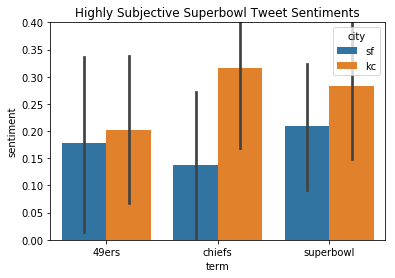

In [65]:
df_sub = df.loc[df['subjective'] > 0.75]
sns.barplot(x='term', y='sentiment', hue='city', data=df_sub).set(ylim=(0, 0.4))
plt.title('Highly Subjective Superbowl Tweet Sentiments')
plt.savefig('imgs/subjective_hist.png')

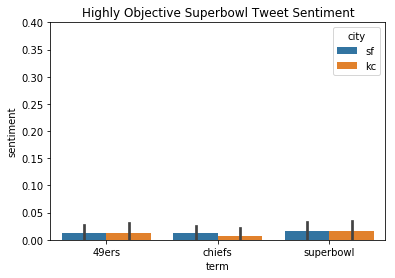

In [66]:
df_obj = df.loc[df['subjective'] <= 0.25]
sns.barplot(x='term', y='sentiment', hue='city', data=df_obj).set(ylim=(0, 0.4))
plt.title('Highly Objective Superbowl Tweet Sentiment')
plt.savefig('imgs/objective_hist.png')

### Weird Results
Why does Kansas City have a lower sentiment for the Chiefs than the 49ers? The Chiefs are KC's home team and they won.

**Answer**: Many of the tweets collected from KC were retweets of several overly influential tweets. Removing retweets from the dataset changed this outcome. 

In [17]:
df_kc = df.loc[df['city'] == 'kc']
df_sf = df.loc[df['city'] == 'sf']

In [18]:
df_sf.sort_values(by='sentiment', ascending=False)

,city,term,tweet,time,sentiment,subjective
73,sf,49ers,defense (playoffs included) in st quarters: pa...,2020-02-04 15:40:33,1.000000,0.300000
1254,sf,superbowl,"best parts of the superbowl: , , , , and .",2020-02-03 19:31:20,1.000000,0.300000
17,sf,49ers,. with the pick! thank you for a wonderful sea...,2020-02-04 18:09:01,1.000000,1.000000
1413,sf,superbowl,happy monday! here's a detox salad after that ...,2020-02-03 15:15:22,1.000000,1.000000
1274,sf,superbowl,you were the winners of superbowl liv! best ha...,2020-02-03 18:54:15,1.000000,0.300000
1310,sf,superbowl,as soon as the superbowl ended i turned on the...,2020-02-03 17:52:27,1.000000,0.571429
544,sf,chiefs,congratulations to you for growing into one of...,2020-02-04 15:16:09,1.000000,0.300000
1400,sf,superbowl,amazing work!!!!!!! ️,2020-02-03 15:54:06,1.000000,0.900000
971,sf,chiefs,how about looking at a map and learning where ...,2020-02-03 17:38:33,1.000000,1.000000
1393,sf,superbowl,"look at this bullshit, we will see all the mis...",2020-02-03 15:58:15,1.000000,0.400000


In [63]:
TextBlob('i hate waking up for school in the morning').sentiment

Sentiment(polarity=-0.8, subjectivity=0.9)

In [64]:
TextBlob('data science incubator is a class taught at usu').sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

### Latent Dirichlet Allocation
[Reference](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

Find topics present in tweets from each city

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

def detect_topics(tweets, n_topics=5, n_words=10, vis=False):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform(df_kc['tweet'])
    
    # Create and fit the LDA model
    lda = LDA(n_components=n_topics, n_jobs=-1)
    lda.fit(count_data)
    
    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    print_topics(lda, count_vectorizer, n_words)
    
    if vis:
        LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
        pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(n_topics) +'.html')

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [20]:
print('Kansas City')
print('---------------------')
detect_topics(df_kc['tweet'])
print()
print('SanFran')
print('---------------------')
detect_topics(df_sf['tweet'])

Kansas City
---------------------
Topics found via LDA:

Topic #0:
chiefs super bowl liv city kansas ers won thank team

Topic #1:
chiefs parade superbowl ers city kansas tomorrow kc team wednesday

Topic #2:
chiefs win ers year bowl superbowl super amp game just

Topic #3:
ers chiefs kansas city mahomes great play think win super

Topic #4:
ers game chiefs superbowl kansas super bowl city won amp

SanFran
---------------------
Topics found via LDA:

Topic #0:
chiefs game year ers mahomes parade just win superbowl amp

Topic #1:
bowl super chiefs ers parade superbowl liv team victory great

Topic #2:
kansas city chiefs ers superbowl won missouri parade amp don

Topic #3:
chiefs kansas city superbowl ers like win champs bowl super

Topic #4:
ers chiefs superbowl game won win team did defense great


In [28]:
print('Overall')
print('----------')
detect_topics(df['tweet'], vis=True)

Overall
----------
Topics found via LDA:

Topic #0:
chiefs ers superbowl win amp game mahomes city just fans

Topic #1:
bowl super chiefs parade kansas city ers tomorrow superbowl win

Topic #2:
chiefs ers great team game kansas city superbowl like just

Topic #3:
superbowl ers chiefs kc twitter game like team people episode

Topic #4:
ers coach year reid superbowl andy guys just work head


/home/zion/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
